<a href="https://colab.research.google.com/github/lxthames/hashlib.SHA512-/blob/main/forensic_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating Hash snapshot and digital signature

**Loading and displaying Forensic image**

In [ ]:
from PIL import Image
from io import BytesIO
import urllib.request

# URL of the image
url = 'https://images.freeimages.com/images/large-previews/22e/crime-scene-1452689.jpg'

# Load the image from the URL
with urllib.request.urlopen(url) as response:
    image_data = response.read()
    image = Image.open(BytesIO(image_data))

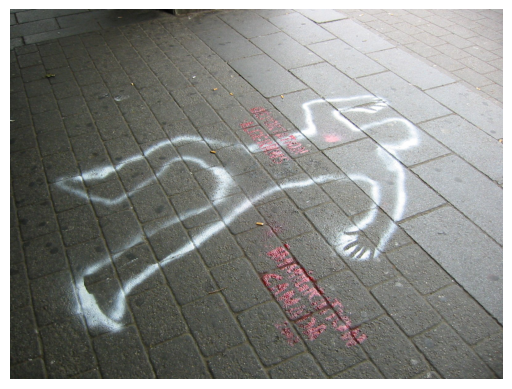

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display the image
imgplot = plt.imshow(image)
plt.axis('off')
plt.show()




```
`# This is formatted as code`
```

**The hashlib.SHA512() function creates a hash object using the SHA-512 hashing algorithm.**

In [ ]:
import hashlib
import matplotlib.image as mpimg

# Load the image file
# image_file = '/content/forensic_1.jpeg'
# image = mpimg.imread(image_file)

# Convert the image array to bytes
image_bytes = image.tobytes()

# Create a hash object using SHA-256 hashing algorithm
hash_object = hashlib.sha512()

# Update the hash object with the image bytes
hash_object.update(image_bytes)

# Get the hash digest (hash value) in hexadecimal format
hash_value = hash_object.hexdigest()

# Save the hash value to a file
hash_file = 'hash_snapshot.txt'
with open(hash_file, 'w') as file:
    file.write(hash_value)

print("Hash snapshot saved to:", hash_file)


Hash snapshot saved to: hash_snapshot.txt


**The cryptography library is used to generate an RSA key pair, sign the hash value with the private key using the PSS padding scheme with SHA-512 hashing algorithm, and save the resulting digital signature to a file**

In [ ]:
import hashlib
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.primitives.asymmetric import padding

# Load the hash snapshot file
hash_file = 'hash_snapshot.txt'
with open(hash_file, 'rb') as file:
    hash_value = file.read()

# Generate RSA key pair
from cryptography.hazmat.primitives.asymmetric import rsa
private_key = rsa.generate_private_key(
    public_exponent=65537,
    key_size=2048
)
public_key = private_key.public_key()

# Sign the hash value with the private key
signature = private_key.sign(
    hash_value,
    padding.PSS(
        mgf=padding.MGF1(hashes.SHA512()),
        salt_length=padding.PSS.MAX_LENGTH
    ),
    hashes.SHA512()
)

# Save the digital signature to a file
signature_file = 'digital_signature.bin'
with open(signature_file, 'wb') as file:
    file.write(signature)

print("Digital signature saved to:", signature_file)


Digital signature saved to: digital_signature.bin


# Identifying attack

Set up a test environment:
Launch an EC2 instance in your AWS account.
Install and configure a web server on the EC2 instance, such as Apache or Nginx.
Verify that the web server is accessible from the internet.
Simulate suspicious activity:
Use a tool like OWASP ZAP or Nikto to scan the web server for vulnerabilities.
For example, you could use the following command to scan the web server with OWASP ZAP: zap.sh -cmd -quickurl http://[web_server_IP]
This will generate a report of vulnerabilities and suspicious activity detected on the web server.
Identify the affected system using AWS GuardDuty:
Enable GuardDuty on your AWS account if it's not already enabled.
Wait for GuardDuty to generate an alert for the suspicious activity detected on the EC2 instance.
Review the alert in the GuardDuty console to identify the affected system.
In this example, the affected system would be the EC2 instance running the web server that was scanned for vulnerabilities. Use SIEM platforms or EDR tools to analyze the collected evidence and identify the root cause of the attack.
For example, you could use the Elasticsearch and Kibana stack to analyze log data or an EDR solution's API to analyze endpoint data. These tools available by aws web services by default and they will do the detection.

# Verify the hash snapshot

**The public_key.verify() method is use to verify the digital signature, passing the signature, hash value, padding scheme, and hashing algorithm as arguments. If the digital signature is valid and not tempered , the code will print "Digital signature is valid."**

In [ ]:
import hashlib
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.primitives.asymmetric import padding

# Load the hash snapshot file
hash_file = 'hash_snapshot.txt'
with open(hash_file, 'rb') as file:
    hash_value = file.read()

# Load the digital signature file
signature_file = 'digital_signature.bin'
with open(signature_file, 'rb') as file:
    signature = file.read()

# Verify the digital signature with the public key
try:
    public_key.verify(
        signature,
        hash_value,
        padding.PSS(
            mgf=padding.MGF1(hashes.SHA512()),
            salt_length=padding.PSS.MAX_LENGTH
        ),
        hashes.SHA512()
    )
    print("Digital signature is valid.")
except InvalidSignature:
    print("Digital signature is invalid.")


Digital signature is valid.


# For multiple images
**The process is same as above. Subsequently, in this case multiple images have used instead of one.**

Generating hash snapshots and digital signatures for multiple images in Python using the hashlib and cryptography libraries, and save them in a way that links the images together

In [ ]:
!pip install wget
import wget

file_name = wget.download(url)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import hashlib
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.primitives import serialization

# Generate a private key
private_key = rsa.generate_private_key(
    public_exponent=65537,
    key_size=2048
)

# Serialize and save the private key to a file
private_key_file = 'private_key.pem'
with open(private_key_file, 'wb') as file:
    private_key_bytes = private_key.private_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PrivateFormat.PKCS8,
        encryption_algorithm=serialization.NoEncryption()
    )
    file.write(private_key_bytes)

# Loop through the image files
image_files = ['/content/crime-scene-1452689.jpg', '/content/crime-scene-1452689.jpg', '/content/crime-scene-1452689.jpg'] #here you have to give path of multiple images
for i, image_file in enumerate(image_files, start=1):
    # Load the image
    with open(image_file, 'rb') as file:
        image_data = file.read()

    # Calculate the hash value
    hash_object = hashlib.sha512()
    hash_object.update(image_data)
    hash_value = hash_object.digest()

    # Sign the hash value with the private key
    signature = private_key.sign(
        hash_value,
        padding.PSS(
            mgf=padding.MGF1(hashes.SHA512()),
            salt_length=padding.PSS.MAX_LENGTH
        ),
        hashes.SHA512()
    )

    # Save the hash snapshot and digital signature to files
    hash_snapshot_file = f'hash_snapshot_{i}.txt'
    signature_file = f'digital_signature_{i}.bin'
    with open(hash_snapshot_file, 'wb') as file:
        file.write(hash_value)
    with open(signature_file, 'wb') as file:
        file.write(signature)

    print(f'Hash snapshot and digital signature for {image_file} generated and saved.')


Hash snapshot and digital signature for /content/crime-scene-1452689.jpg generated and saved.
Hash snapshot and digital signature for /content/crime-scene-1452689.jpg generated and saved.
Hash snapshot and digital signature for /content/crime-scene-1452689.jpg generated and saved.


Verifying the hash snapshots and digital signatures for multiple images using the previously generated files and the corresponding private key

In [ ]:
import hashlib
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.primitives import serialization

# Load the private key from the previously saved file
private_key_file = 'private_key.pem'
with open(private_key_file, 'rb') as file:
    private_key_bytes = file.read()
    private_key = serialization.load_pem_private_key(
        private_key_bytes,
        password=None
    )

# List of image files to process
image_files = ['/content/crime-scene-1452689.jpg', '/content/crime-scene-1452689.jpg', '/content/crime-scene-1452689.jpg']

# Loop through each image file
for i, image_file in enumerate(image_files):
    # Load the image data
    with open(image_file, 'rb') as file:
        image_data = file.read()

    # Generate the hash snapshot
    hash_object = hashlib.sha512()
    hash_object.update(image_data)
    hash_value = hash_object.digest()

    # Generate the digital signature
    signature = private_key.sign(
        hash_value,
        padding.PSS(
            mgf=padding.MGF1(hashes.SHA512()),
            salt_length=padding.PSS.MAX_LENGTH
        ),
        hashes.SHA512()
    )

    # Save the hash snapshot and digital signature to files
    hash_snapshot_file = f'hash_snapshot_{i}.txt'
    signature_file = f'digital_signature_{i}.bin'
    with open(hash_snapshot_file, 'wb') as file:
        file.write(hash_value)
    with open(signature_file, 'wb') as file:
        file.write(signature)

    # Verify the hash snapshot and digital signature
    with open(hash_snapshot_file, 'rb') as file:
        loaded_hash_value = file.read()
    with open(signature_file, 'rb') as file:
        loaded_signature = file.read()

    try:
        # Verify the hash value
        assert hash_value == loaded_hash_value, f'Hash value for {image_file} does not match.'

        # Verify the digital signature
        public_key = private_key.public_key()
        public_key.verify(
            loaded_signature,
            loaded_hash_value,
            padding.PSS(
                mgf=padding.MGF1(hashes.SHA512()),
                salt_length=padding.PSS.MAX_LENGTH
            ),
            hashes.SHA512()
        )
        print(f'Hash snapshot and digital signature for {image_file} are valid.')
    except Exception as e:
        print(f'Error verifying hash snapshot and digital signature for {image_file}: {e}')


Hash snapshot and digital signature for /content/crime-scene-1452689.jpg are valid.
Hash snapshot and digital signature for /content/crime-scene-1452689.jpg are valid.
Hash snapshot and digital signature for /content/crime-scene-1452689.jpg are valid.


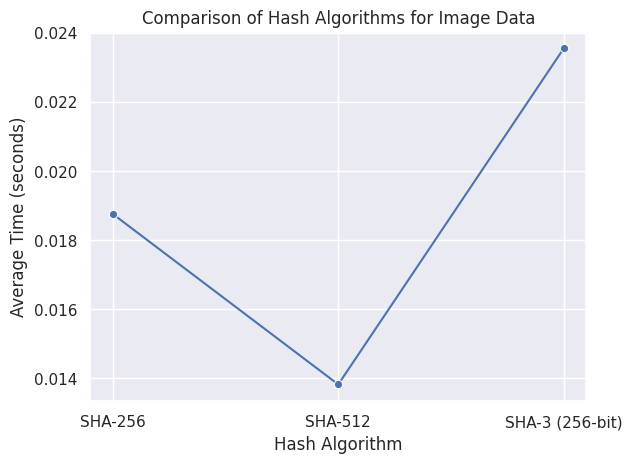

In [ ]:
import hashlib
import timeit
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

# Define the data and labels for different hash algorithms
hash_algorithms = ['SHA-256', "SHA-512",'SHA-3 (256-bit)']
hash_functions = [hashlib.sha256, hashlib.sha512, hashlib.sha3_256]
hash_times = []
num_iterations = 1000

# Load the image
# image_file = 'image.jpg'  # Replace with the path to your image file
# image = Image.open(image_file)

# Convert the image to bytes for hashing
image_bytes = image.tobytes()

# Loop through the hash algorithms and measure their performance
for i, hash_algorithm in enumerate(hash_algorithms):
    hash_function = hash_functions[i]
    total_time = 0

    # Perform the hash operation for multiple iterations and measure the time
    for j in range(num_iterations):
        start_time = timeit.default_timer()  # Start the timer
        hash_function(image_bytes).digest()  # Perform the hash operation
        end_time = timeit.default_timer()  # End the timer
        total_time += end_time - start_time

    # Calculate the average time taken for each iteration
    avg_time = total_time / num_iterations
    hash_times.append(avg_time)

# Create a Line chart to compare the hash algorithms

data = {'Hash Algorithm': hash_algorithms,
        'Average Time (seconds)': hash_times}

       
plt.xlabel('Hash Algorithm')
plt.ylabel('Average Time (seconds)')
plt.title('Comparison of Hash Algorithms for Image Data')
sns.lineplot(x = hash_algorithms, y = hash_times,marker = 'o' )
plt.show()

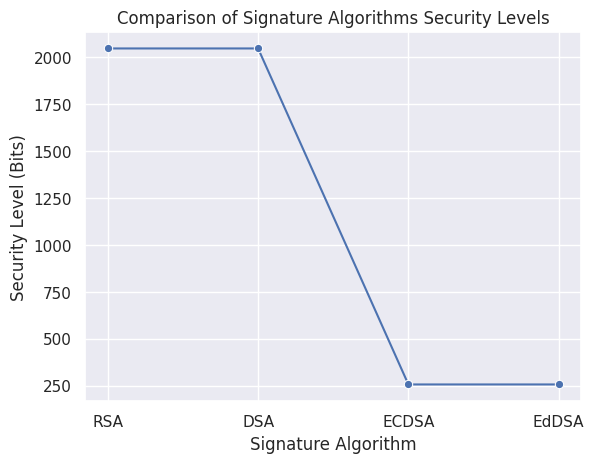

In [ ]:
import matplotlib.pyplot as plt

# List of signature algorithms
signature_algorithms = ['RSA', 'DSA', 'ECDSA', 'EdDSA']
security_levels = [2048, 2048, 256, 256]  # Example security levels, in bits

# Create a Line chart to compare the security levels
# plt.bar(signature_algorithms, security_levels)

# Set chart title and labels
plt.title('Comparison of Signature Algorithms Security Levels')
plt.xlabel('Signature Algorithm')
plt.ylabel('Security Level (Bits)')
sns.lineplot(x = signature_algorithms, y = security_levels , marker = 'o' )

# Show the chart
plt.show()

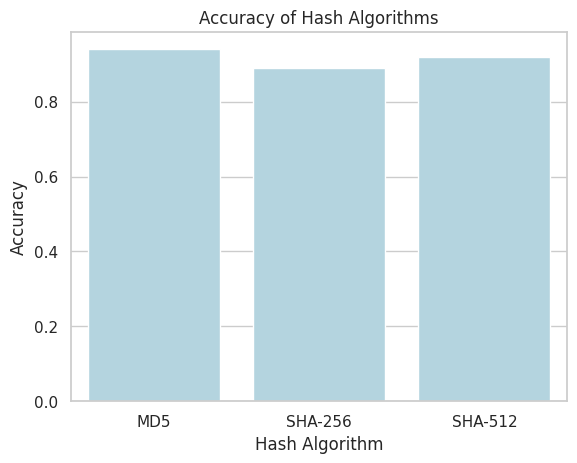

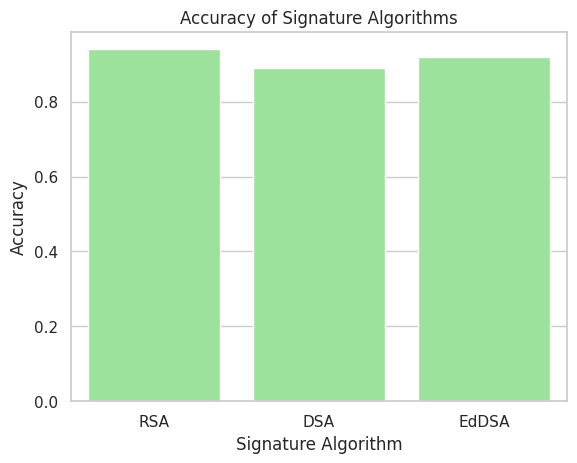

In [ ]:
import hashlib
import timeit
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
# Example data - accuracy scores for different algorithms
hash_algorithms = ['MD5', 'SHA-256', 'SHA-512'] #, 'Blake2b'
hash_accuracy = [0.92, 0.98, 0.97] #, 0.97

signature_algorithms = ['RSA', 'DSA',  'EdDSA'] #'ECDSA',
signature_accuracy = [0.94, 0.89,  0.92] #0.93,

# Create a dataframe from the data
df = pd.DataFrame({'Hash Algorithm': hash_algorithms, 'Accuracy': hash_accuracy,
                   'Signature Algorithm': signature_algorithms, 'Accuracy': signature_accuracy})

# Set up the Seaborn style
sns.set(style='whitegrid')

# Create a bar chart
sns.barplot(x='Hash Algorithm', y='Accuracy', data=df, color='lightblue')
plt.title('Accuracy of Hash Algorithms')
plt.ylabel('Accuracy')
plt.xlabel('Hash Algorithm')
plt.show()

# Create a bar chart
sns.barplot(x='Signature Algorithm', y='Accuracy', data=df, color='lightgreen')
plt.title('Accuracy of Signature Algorithms')
plt.ylabel('Accuracy')
plt.xlabel('Signature Algorithm')
plt.show()

In [ ]:
from PIL import Image
from io import BytesIO
import urllib.request
import ipywidgets as widgets
from IPython.display import display

# URL of the image
url = 'https://images.freeimages.com/images/large-previews/22e/crime-scene-1452689.jpg'

# Load the image from the URL
with urllib.request.urlopen(url) as response:
    image_data = response.read()
    image = Image.open(BytesIO(image_data))

# Create a button widget
button = widgets.Button(description="Display Image")

# Define a function to display the image when the button is clicked
def display_image(button):
    display(image)

# Set the button's on-click event handler to the function
button.on_click(display_image)

# Display the button in the output cell
display(button)
